In [1]:
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from tqdm import tqdm
from sklearn.cluster import KMeans, DBSCAN
from sklearn_extra.cluster import KMedoids
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier

import time
from math import *
import re
import pandas as pd
import random as rd
import seaborn as sns

signatures_path = './signatures/'

BDD_path = 'bdd/'
visu_signatures_path = signatures_path + BDD_path

complex_4G_path = signatures_path + 'complex_4G.txt'
complex_8G_path = signatures_path + 'complex_8G.txt'
complex_24G_path = signatures_path + 'complex_24G.txt'

# Introduction

### Visualisation des données

In [2]:
def plot_signature(signature_name):
    
    if signature_name[-4:] != '.txt':
        #print('oublie du .txt à la fin')
        signature_name += '.txt'
    
    with open(visu_signatures_path + signature_name) as file:
        lines = file.readlines()
        lines_splited = []
        
        for k in range(len(lines)):
            lines_splited.append(lines[k].split())
            for j in range(5):
                lines_splited[k][j] = int(lines_splited[k][j])
        
        x = [lines_splited[i][0] for i in range(len(lines_splited))]
        y = [lines_splited[i][1] for i in range(len(lines_splited))]
        plt.figure(figsize=(7,7))
        plt.title('Signature ' + signature_name[:-4])
        plt.plot(x,y,'o')
        plt.plot()

#lot_signature('17v1')

In [82]:
def complexity(complexity_path):
    # chaque ligne correspond à une personne 
    # on va return la liste complexity_people
    # complexity_people[k] correspond à la liste des 25 signatures de la kème personne 
    
    if complexity_path not in [complex_4G_path, complex_8G_path, complex_24G_path]:
        print('Fichier inconnue', [complex_4G_path, complex_8G_path, complex_24G_path])
        
    with open(complexity_path) as file:
        lines = file.readlines()
        complexity_people = []
        
        for j in range(100):
            complexity_people.append(list(map(float,[s.replace(',','.') for s in lines[j].split()]))) 
            # on transforme la liste de str en liste de int en passant par map 
            # attention à remplacer les virgules par des points
        
        return complexity_people

complexity4G_people = np.array(complexity(complex_4G_path))
complexity8G_people = np.array(complexity(complex_8G_path))
complexity24G_people = np.array(complexity(complex_24G_path))

complexity_avg_4G = np.array([np.mean(complexity4G_people[j,:]) for j in range(len(complexity4G_people))]).reshape(-1, 1)
complexity_avg_8G = np.array([np.mean(complexity8G_people[j,:]) for j in range(len(complexity8G_people))]).reshape(-1, 1)
complexity_avg_24G = np.array([np.mean(complexity24G_people[j,:]) for j in range(len(complexity24G_people))]).reshape(-1, 1)

In [4]:
def plot_hist_complexity(complexity_people):
    
    if (complexity_people == complexity4G_people).all():
        number_gaussian = 4
        
    elif (complexity_people == complexity8G_people).all():
        number_gaussian = 8
        
    elif (complexity_people == complexity24G_people).all():
        number_gaussian = 24
    
    else:
        print("complexity_people n'existe pas")
        
    data = []
    for i in range(len(complexity_people)):
        data += complexity_people.tolist()[i]
    
    # Créer une figure avec deux sous-graphiques
    fig, axes = plt.subplots(nrows=2, figsize=(15,8))

    # Premier sous-graphique : histogramme
    sns.histplot(data, kde=False, ax=axes[0])
    axes[0].set_ylabel('Fréquence')

    # Deuxième sous-graphique : stripplot
    sns.stripplot(x=data, jitter=False, ax=axes[1])
    title_str = 'Complexité des signatures avec ' + str(number_gaussian) + ' gaussiennes'
    axes[1].set_xlabel(title_str)
    
    # Modifier la position et la taille de la deuxième sous-figure
    pos = axes[1].get_position()
    axes[1].set_position([pos.x0, pos.y0*3.5, pos.width, pos.height/5])
    
    # Afficher la figure
    plt.show()
    
#plot_hist_complexity(complexity4G_people)
#plot_hist_complexity(complexity8G_people)
#plot_hist_complexity(complexity24G_people)

In [5]:
def plot_complexities_mean():
    
    # créer une figure avec trois subplots
    fig, axes = plt.subplots(nrows=3, figsize=(20, 6),sharex=True)

    # créer les stripplots sur chaque subplot
    sns.stripplot(x=complexity_avg_4G.flatten(),jitter=False,ax=axes[0])
    axes[0].set_title('Complexité des signatures moyennées sur les personnes avec 4 gaussiennes')
    sns.stripplot(x=complexity_avg_8G.flatten(),jitter=False, ax=axes[1])
    axes[1].set_title('Complexité des signatures moyennées sur les personnes avec 8 gaussiennes')
    sns.stripplot(x=complexity_avg_24G.flatten(),jitter=False, ax=axes[2])
    axes[2].set_title('Complexité des signatures moyennées sur les personnes avec 24 gaussiennes')

    # ajuster les marges et les étiquettes de la figure
    plt.subplots_adjust(wspace=0.3)

    # afficher la figure
    plt.show()

#plot_complexities_mean()

In [6]:
def plot_complexity_mean(complexity_avg):
    
    if (complexity_avg == complexity_avg_4G).all():
        number_gaussian = 4
        
    elif (complexity_avg == complexity_avg_8G).all():
        number_gaussian = 8
        
    elif (complexity_avg == complexity_avg_24G).all():
        number_gaussian = 24
    
    else:
        print("complexity_people n'existe pas")
        
    plt.figure(figsize=(15, 2))
    sns.stripplot(x=complexity_avg.flatten(),jitter=False)
    title_str = 'Complexité des signatures avec ' + str(number_gaussian) + ' gaussiennes'
    plt.title(title_str)
    plt.show()
    
#plot_complexity_mean(complexity_avg_4G)
#plot_complexity_mean(complexity_avg_8G)
#plot_complexity_mean(complexity_avg_24G)

# 1. Classification non-supervisées des personnes pour analyser l’apport de la mesure de complexité

### Avec K-means

In [7]:
kmeans_4G = KMeans(n_clusters=3 , init='k-means++', n_init=10, max_iter=200).fit(complexity_avg_4G)
kmeans_8G= KMeans(n_clusters=3 , init='k-means++', n_init=10, max_iter=200).fit(complexity_avg_8G)
kmeans_24G= KMeans(n_clusters=3 , init='k-means++', n_init=10, max_iter=200).fit(complexity_avg_24G)

color = ['cluster 1','cluster 2','cluster 3']

def plot_kmeans(complexity_avg):
         
    if (complexity_avg == complexity_avg_4G).all():
        number_gaussian = 4
        cluster_colors = [color[label] for label in kmeans_4G.labels_]
        centroids = kmeans_4G.cluster_centers_
        centroids_colors = [color[label] for label in kmeans_4G.predict(centroids).tolist()]
        
    elif (complexity_avg == complexity_avg_8G).all():
        number_gaussian = 8
        cluster_colors = [color[label] for label in kmeans_8G.labels_]
        centroids = kmeans_8G.cluster_centers_
        centroids_colors = [color[label] for label in kmeans_8G.predict(centroids).tolist()]
        
    elif (complexity_avg == complexity_avg_24G).all():
        number_gaussian = 24
        cluster_colors = [color[label] for label in kmeans_24G.labels_]
        centroids = kmeans_24G.cluster_centers_
        centroids_colors = [color[label] for label in kmeans_24G.predict(centroids).tolist()]
        
    else:
        print(complexity_avg, ' n\'existe pas')
        
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 4))

    # tracer le stripplot avec jitter=False sur le premier sous-graphique
    sns.stripplot(x=complexity_avg.flatten(),y=cluster_colors,hue=cluster_colors,jitter=False, ax=axes[0])
    axes[0].scatter(centroids, centroids_colors, marker='x', s=100, linewidth=2, color='k',label='centroids')

    # tracer le stripplot avec jitter=True sur le deuxième sous-graphique
    sns.stripplot(x=complexity_avg.flatten(),hue=cluster_colors,jitter=False, ax=axes[1],size=4)
    axes[1].scatter(centroids, [0]*len(centroids), marker='x', s=100, linewidth=2, color='k',label='centroids')

    # ajuster les marges et les étiquettes de la figure
    plt.subplots_adjust(wspace=0.3)
    title = 'Clustering des complexités ('+ str(number_gaussian) +'G) avec KMeans'
    plt.suptitle(title)

    # créer une légende unique
    axes[0].legend_.remove()
    axes[1].legend_.remove()
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', ncol=len(labels))
    axes[1].set_xlabel('Complexité')

    # Modifier la position et la taille de la deuxième sous-figure
    pos = axes[1].get_position()
    axes[1].set_position([pos.x0, pos.y0*2, pos.width, pos.height/2])

    # afficher la figure
    plt.show()
    
#plot_kmeans(complexity_avg_4G)
#plot_kmeans(complexity_avg_8G)
#plot_kmeans(complexity_avg_24G)

In [8]:
mylabels = ["Cluster 1", "Cluster 2", "Cluster 3"]

pourcentages_4G = [0]*3
for label in kmeans_4G.labels_:
    pourcentages_4G[label] += 1

#plt.figure(figsize=(6,6))
#pourcentages_4G = np.array(pourcentages_4G)/100
#plt.pie(pourcentages_4G,labels=mylabels,shadow = True)
#plt.title('Pourcentage de personnes en chaque cluster pour 4G')
#plt.legend(loc='upper left')
#plt.show()

pourcentages_8G = [0]*3
for label in kmeans_8G.labels_:
    pourcentages_8G[label] += 1

#plt.figure(figsize=(6,6))
#pourcentages_8G = np.array(pourcentages_8G)/100
#plt.pie(pourcentages_8G,labels=mylabels,shadow = True)
#plt.title('Pourcentage de personnes en chaque cluster pour 8G')
#plt.legend(loc='upper left')
#plt.show()

pourcentages_24G = [0]*3
for label in kmeans_24G.labels_:
    pourcentages_24G[label] += 1

#plt.figure(figsize=(6,6))
#pourcentages_24G = np.array(pourcentages_24G)/100
#plt.pie(pourcentages_24G,labels=mylabels,shadow = True)
#plt.title('Pourcentage de personnes en chaque cluster pour 24G')
#plt.legend(loc='upper left')
#plt.show()

In [9]:
intra_inertia_4G = kmeans_4G.inertia_
intra_inertia_8G = kmeans_8G.inertia_
intra_inertia_24G = kmeans_24G.inertia_
intra_inertia_4G,intra_inertia_8G,intra_inertia_24G

(30.09941961002361, 50.84820550342409, 183.03997120592152)

In [10]:
kmeans_24G.score(complexity_avg_4G)

-1285.8812062164757

### Avec K-medoids

In [11]:
kmedoids_4G = KMedoids(n_clusters=3, init='heuristic').fit(complexity_avg_4G)
kmedoids_8G= KMedoids(n_clusters=3, init='heuristic').fit(complexity_avg_8G)
kmedoids_24G= KMedoids(n_clusters=3, init='heuristic').fit(complexity_avg_24G)

color = ['cluster 1','cluster 2','cluster 3']

def plot_kmedoids(complexity_avg):
         
    if (complexity_avg == complexity_avg_4G).all():
        number_gaussian = 4
        cluster_colors = [color[label] for label in kmedoids_4G.labels_]
        centroids = kmedoids_4G.cluster_centers_
        centroids_colors = [color[label] for label in kmedoids_4G.predict(centroids).tolist()]
        
    elif (complexity_avg == complexity_avg_8G).all():
        number_gaussian = 8
        cluster_colors = [color[label] for label in kmedoids_8G.labels_]
        centroids = kmedoids_8G.cluster_centers_
        centroids_colors = [color[label] for label in kmedoids_8G.predict(centroids).tolist()]
        
    elif (complexity_avg == complexity_avg_24G).all():
        number_gaussian = 24
        cluster_colors = [color[label] for label in kmedoids_24G.labels_]
        centroids = kmedoids_24G.cluster_centers_
        centroids_colors = [color[label] for label in kmedoids_24G.predict(centroids).tolist()]
        
    else:
        print(complexity_avg, ' n\'existe pas')
        
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 4))

    # tracer le stripplot avec jitter=False sur le premier sous-graphique
    sns.stripplot(x=complexity_avg.flatten(),y=cluster_colors,hue=cluster_colors,jitter=False, ax=axes[0])
    axes[0].scatter(centroids, centroids_colors, marker='x', s=100, linewidth=2, color='k',label='centroids')

    # tracer le stripplot avec jitter=True sur le deuxième sous-graphique
    sns.stripplot(x=complexity_avg.flatten(),hue=cluster_colors,jitter=False, ax=axes[1],size=4)
    axes[1].scatter(centroids, [0]*len(centroids), marker='x', s=100, linewidth=2, color='k',label='centroids')

    # ajuster les marges et les étiquettes de la figure
    plt.subplots_adjust(wspace=0.3)
    title = 'Clustering des complexités ('+ str(number_gaussian) +'G) avec KMedoids'
    plt.suptitle(title)

    # créer une légende unique
    axes[0].legend_.remove()
    axes[1].legend_.remove()
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', ncol=len(labels))
    axes[1].set_xlabel('Complexité')

    # Modifier la position et la taille de la deuxième sous-figure
    pos = axes[1].get_position()
    axes[1].set_position([pos.x0, pos.y0*2, pos.width, pos.height/2])

    # afficher la figure
    plt.show()
    
#plot_kmedoids(complexity_avg_4G)
#plot_kmedoids(complexity_avg_8G)
#plot_kmedoids(complexity_avg_24G)

In [12]:
mylabels = ["Cluster 1", "Cluster 2", "Cluster 3"]

pourcentages_4G = [0]*3
for label in kmedoids_4G.labels_:
    pourcentages_4G[label] += 1

#plt.figure(figsize=(6,6))
#pourcentages_4G = np.array(pourcentages_4G)/100
#plt.pie(pourcentages_4G,labels=mylabels,shadow = True)
#plt.title('Pourcentage de personnes en chaque cluster pour 4G avec KMedoids')
#plt.legend(loc='upper left')
#plt.show()

pourcentages_8G = [0]*3
for label in kmedoids_8G.labels_:
    pourcentages_8G[label] += 1

#plt.figure(figsize=(6,6))
#pourcentages_8G = np.array(pourcentages_8G)/100
#plt.pie(pourcentages_8G,labels=mylabels,shadow = True)
#plt.title('Pourcentage de personnes en chaque cluster pour 8G avec KMedoids')
#plt.legend(loc='upper left')
#plt.show()

pourcentages_24G = [0]*3
for label in kmedoids_24G.labels_:
    pourcentages_24G[label] += 1

#plt.figure(figsize=(6,6))
#pourcentages_24G = np.array(pourcentages_24G)/100
#plt.pie(pourcentages_24G,labels=mylabels,shadow = True)
#plt.title('Pourcentage de personnes en chaque cluster pour 24G avec KMedoids')
#plt.legend(loc='upper left')
#plt.show()

In [13]:
intra_inertia_4G = kmedoids_4G.inertia_
intra_inertia_8G = kmedoids_8G.inertia_
intra_inertia_24G = kmedoids_24G.inertia_
intra_inertia_4G,intra_inertia_8G,intra_inertia_24G

(47.12588573431176, 69.83392409336251, 99.78175835425839)

### Avec DBSCAN

In [14]:
def optimise_eps(complexity_avg_4G,NG):
    n_samples = np.shape(complexity_avg_4G)[0]
    random_state = 170

    neigh = NearestNeighbors(n_neighbors=3)
    nbrs = neigh.fit(complexity_avg_4G)
    distances, indices = nbrs.kneighbors(complexity_avg_4G)
    distances = np.sort(distances, axis=0)
    distances = distances[:,1]

    plt.figure(figsize=(6,6))
    str_title = 'eps optimal pour ' + str(NG) + ' Gaussiennes'
    plt.title(str_title)
    plt.plot(distances)
    plt.axvline(x=0.90 * n_samples, color='black', linestyle='--')
    plt.show()

# Optimise eps pour 4G
#optimise_eps(complexity_avg_4G,4)
eps4G = 0.2

# Optimise eps pour 8G
#optimise_eps(complexity_avg_8G,8)
eps8G = 1

# Optimise eps pour 24G
#optimise_eps(complexity_avg_24G,24)
eps24G = 1

In [15]:
dbscan_4G = DBSCAN(eps=eps4G).fit(complexity_avg_4G)
dbscan_8G = DBSCAN(eps=eps8G).fit(complexity_avg_8G)
dbscan_24G = DBSCAN(eps=eps24G).fit(complexity_avg_24G)

color = ["cluster " + str(i) for i in range(1,11)]

In [16]:
def intra_inertia_DBSCAN(dbscan,complexity_avg):
    
    if (complexity_avg == complexity_avg_4G).all():
        number_gaussian = 4
    elif (complexity_avg == complexity_avg_8G).all():
        number_gaussian = 8
    elif (complexity_avg == complexity_avg_24G).all():
        number_gaussian = 24
    else :
        print('problème')
        
    dbscan_labels = dbscan.fit_predict(complexity_avg)
    X = np.array(complexity_avg)

    # Trouver les centres de cluster (ignorer les valeurs -1 qui représentent les points considérés comme du bruit)
    cluster_centers = []
    for label in np.unique(dbscan_labels):
        if label != -1:
            cluster_centers.append(np.mean(X[dbscan_labels == label]))

    # Calculer la somme des carrés des distances pour chaque cluster identifié
    inertia = 0
    for i, center in enumerate(cluster_centers):
        distances = euclidean_distances(X[dbscan_labels == i], center.reshape(-1,1))
        inertia += np.sum(distances ** 2)

    print("Inertie intra cluster pour DBSCAN " + str(number_gaussian) + "G : ", inertia)

intra_inertia_DBSCAN(dbscan_4G,complexity_avg_4G)
intra_inertia_DBSCAN(dbscan_8G,complexity_avg_8G)
intra_inertia_DBSCAN(dbscan_24G,complexity_avg_24G)

Inertie intra cluster pour DBSCAN 4G :  61.13239638261791
Inertie intra cluster pour DBSCAN 8G :  147.11712232242945
Inertie intra cluster pour DBSCAN 24G :  294.1988737448735


In [17]:
def plot_dbscan(complexity_avg):
    
    print('--------------------------------')
         
    if (complexity_avg == complexity_avg_4G).all():
        number_gaussian = 4
        cluster_colors = [color[label] for label in dbscan_4G.labels_]
        eps = eps4G
        print('4 Gausiennes avec eps=',eps)
        
    elif (complexity_avg == complexity_avg_8G).all():
        number_gaussian = 8
        cluster_colors = [color[label] for label in dbscan_8G.labels_]
        eps = eps8G
        print('8 Gausiennes avec eps=',eps)
        
    elif (complexity_avg == complexity_avg_24G).all():
        number_gaussian = 24
        cluster_colors = [color[label] for label in dbscan_24G.labels_]
        eps = eps24G
        print('24 Gausiennes avec eps=',eps)
        
    else:
        print(complexity_avg, ' n\'existe pas')
    
    print("Il y a",len(np.unique(dbscan_4G.labels_)),"labels différent")
    
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 4))

    # tracer le stripplot sur trois lignes sur le premier sous-graphique
    sns.stripplot(x=complexity_avg.flatten(),y=cluster_colors,hue=cluster_colors,jitter=False, ax=axes[0])

    # tracer le stripplot sur une même ligne sur le deuxième sous-graphique
    sns.stripplot(x=complexity_avg.flatten(),hue=cluster_colors,jitter=False, ax=axes[1],size=4)

    # ajuster les marges et les étiquettes de la figure
    plt.subplots_adjust(wspace=0.3)
    title = 'Clustering des complexités ('+ str(number_gaussian) +'G) avec DBSCAN avec eps =' + str(eps)
    plt.suptitle(title)

    # créer une légende unique
    axes[0].legend_.remove()
    axes[1].legend_.remove()
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', ncol=len(labels))
    axes[1].set_xlabel('Complexité')

    # Modifier la position et la taille de la deuxième sous-figure
    pos = axes[1].get_position()
    axes[1].set_position([pos.x0, pos.y0*2, pos.width, pos.height/2])

    # afficher la figure
    plt.show()
    
#plot_dbscan(complexity_avg_4G)
#plot_dbscan(complexity_avg_8G)
#plot_dbscan(complexity_avg_24G)

In [18]:
mylabels = ["Cluster 1", "Cluster 2", "Cluster 3"]

pourcentages_4G = [0]*3
for label in dbscan_4G.labels_:
    pourcentages_4G[label] += 1

#plt.figure(figsize=(6,6))
#pourcentages_4G = np.array(pourcentages_4G)/100
#plt.pie(pourcentages_4G,labels=mylabels,shadow = True)
#plt.title('Pourcentage de personnes en chaque cluster pour 4G avec DBSCAN')
#plt.legend(loc='upper left')
#plt.show()

pourcentages_8G = [0]*3
for label in dbscan_8G.labels_:
    pourcentages_8G[label] += 1

#plt.figure(figsize=(6,6))
#pourcentages_8G = np.array(pourcentages_8G)/100
#plt.pie(pourcentages_8G,labels=mylabels,shadow = True)
#plt.title('Pourcentage de personnes en chaque cluster pour 8G avec DBSCAN')
#plt.legend(loc='upper left')
#plt.show()

pourcentages_24G = [0]*3
for label in dbscan_24G.labels_:
    pourcentages_24G[label] += 1

#plt.figure(figsize=(6,6))
#pourcentages_24G = np.array(pourcentages_24G)/100
#plt.pie(pourcentages_24G,labels=mylabels,shadow = True)
#plt.title('Pourcentage de personnes en chaque cluster pour 24G avec DBSCAN')
#plt.legend(loc='upper left')
#plt.show()

# 2. Classification non-supervisées des signatures

In [19]:
# complexity_people[k] correspond à la liste des 25 signatures de la kème personne
complexity24G_people_concatenated = []
for k in range(len(complexity24G_people)):
    complexity24G_people_concatenated += complexity24G_people[k].tolist()

complexity24G_people_concatenated = np.array(complexity24G_people_concatenated).reshape(-1, 1)
kmeans_24G = KMeans(n_clusters=3 , init='k-means++', n_init=10, max_iter=200).fit(complexity24G_people_concatenated)

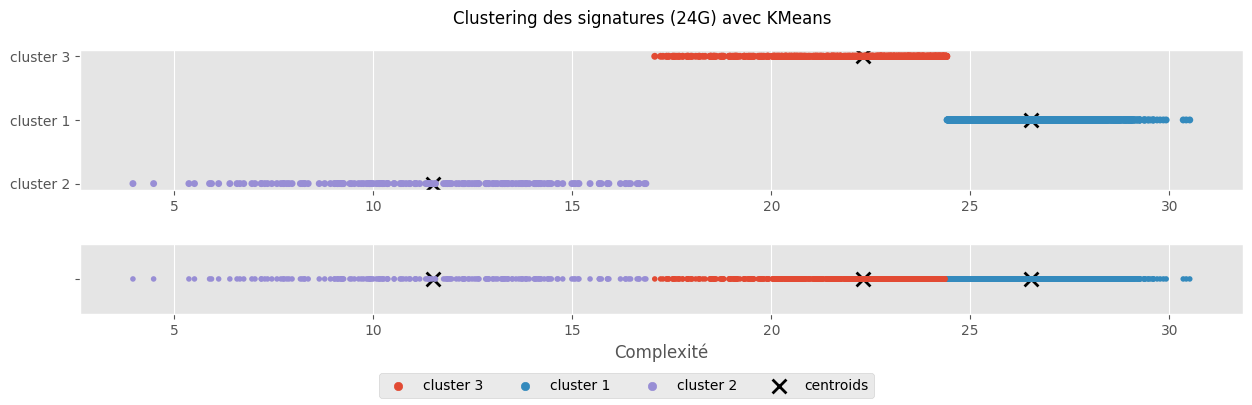

In [20]:
color = ['cluster 1','cluster 2','cluster 3']

number_gaussian = 24
cluster_colors = [color[label] for label in kmeans_24G.labels_]
centroids = kmeans_24G.cluster_centers_
centroids_colors = [color[label] for label in kmeans_24G.predict(centroids).tolist()]
        
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 4))

# tracer le stripplot avec jitter=False sur le premier sous-graphique
sns.stripplot(x=complexity24G_people_concatenated.flatten(),y=cluster_colors,hue=cluster_colors,jitter=False, ax=axes[0])
axes[0].scatter(centroids, centroids_colors, marker='x', s=100, linewidth=2, color='k',label='centroids')

# tracer le stripplot avec jitter=True sur le deuxième sous-graphique
sns.stripplot(x=complexity24G_people_concatenated.flatten(),hue=cluster_colors,jitter=False, ax=axes[1],size=4)
axes[1].scatter(centroids, [0]*len(centroids), marker='x', s=100, linewidth=2, color='k',label='centroids')

# ajuster les marges et les étiquettes de la figure
plt.subplots_adjust(wspace=0.3)
title = 'Clustering des signatures ('+ str(number_gaussian) +'G) avec KMeans'
plt.suptitle(title)

# créer une légende unique
axes[0].legend_.remove()
axes[1].legend_.remove()
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=len(labels))
axes[1].set_xlabel('Complexité')

# Modifier la position et la taille de la deuxième sous-figure
pos = axes[1].get_position()
axes[1].set_position([pos.x0, pos.y0*2, pos.width, pos.height/2])

# afficher la figure
plt.show()

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 29.85it/s]


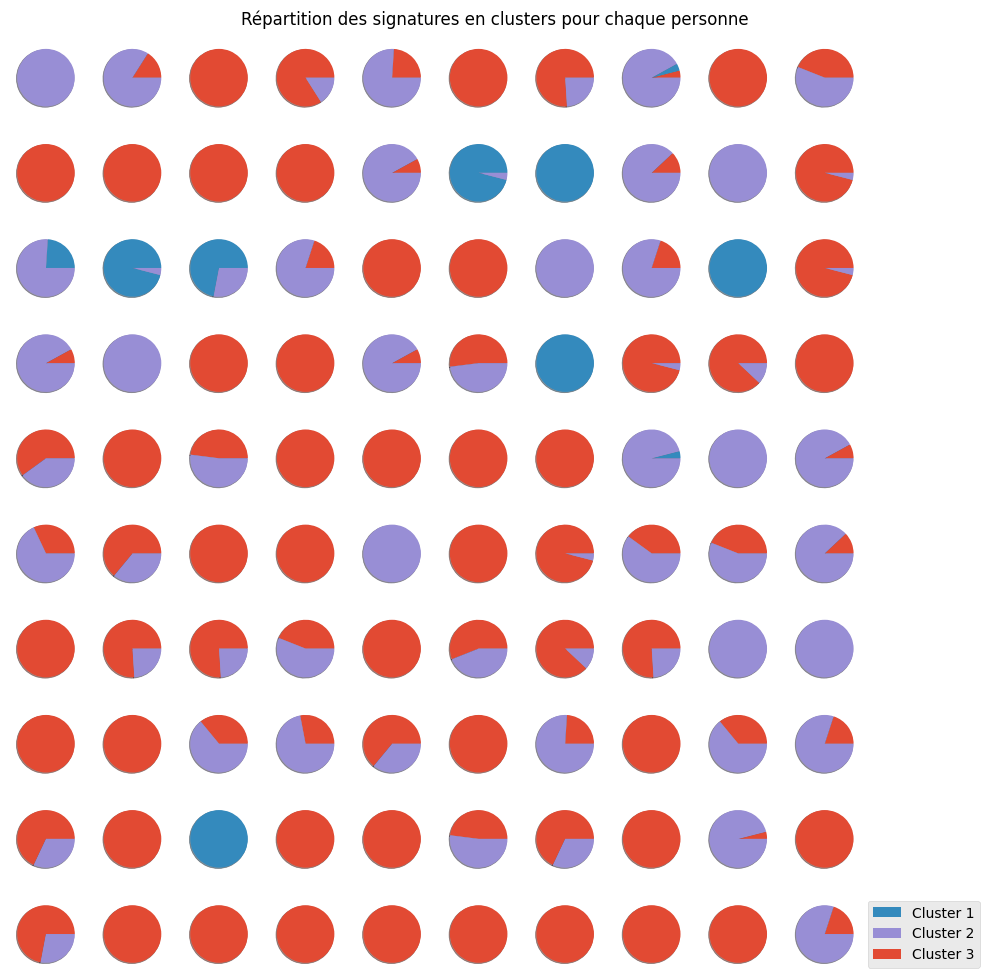

In [21]:
# Pour chaque personne, compute :
# [% des signatures dans le cluster 1, % des signatures dans le cluster 2, % des signatures dans le cluster 2]

labels_matrix = np.array(kmeans_24G.labels_).reshape(100, 25)

proportions = []
clusters = [0, 1, 2]
for person_id in range(100):
    proportions.append(np.array([np.shape(np.where(labels_matrix[person_id,:] == cluster))[1] for cluster in clusters])/25)
    
# Visualisation
plt.figure(figsize=(10, 10))  # Définir la taille de la figure

for i in tqdm(range(100)):
    plt.subplot(10, 10, i+1)
    patches, texts = plt.pie(proportions[i],shadow = True)

# Déplacer la légende à l'extérieur de la figure
plt.legend([patches[1], patches[2], patches[0]], ["Cluster 1", "Cluster 2", "Cluster 3"], loc='center left', bbox_to_anchor=(1, 0.5))
plt.suptitle("Répartition des signatures en clusters pour chaque personne") 

plt.tight_layout()  # Ajuster automatiquement la disposition des sous-tracés
plt.show()

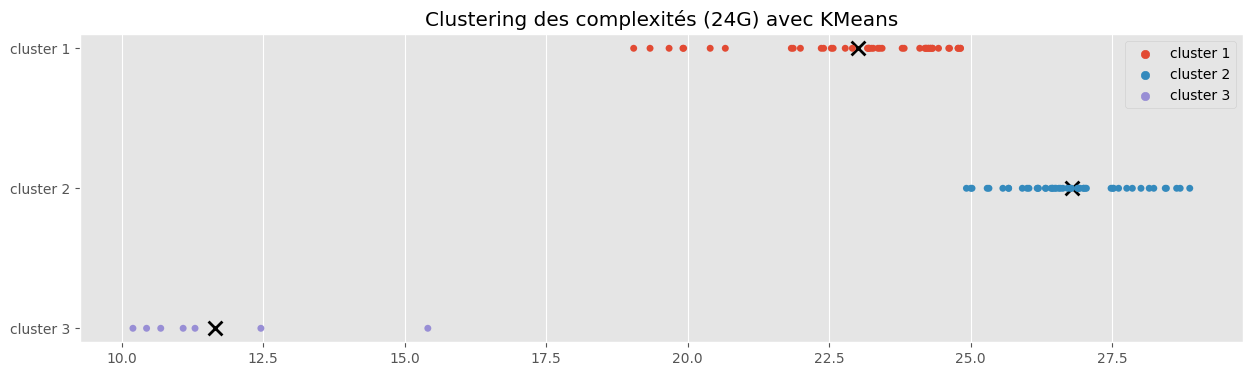

In [90]:
kmeans_24G= KMeans(n_clusters=3 , init='k-means++', n_init=10, max_iter=200).fit(complexity_avg_24G)

color = ['cluster 1','cluster 2','cluster 3']
      
number_gaussian = 24
cluster_colors = [color[label] for label in kmeans_24G.labels_]
centroids = kmeans_24G.cluster_centers_
centroids_colors = [color[label] for label in kmeans_24G.predict(centroids).tolist()]
              
plt.figure(figsize=(15, 4))

# tracer le stripplot avec jitter=False sur le premier sous-graphique
sns.stripplot(x=complexity_avg_24G.flatten(),y=cluster_colors,hue=cluster_colors,jitter=False)
plt.scatter(centroids, centroids_colors, marker='x', s=100, linewidth=2, color='k',label='centroids')

# ajuster les marges et les étiquettes de la figure
title = 'Clustering des complexités ('+ str(number_gaussian) +'G) avec KMeans'
plt.title(title)

# afficher la figure
plt.show()

### Classification des personnes par leurs 25 signatures

C:\Users\utilisateur\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


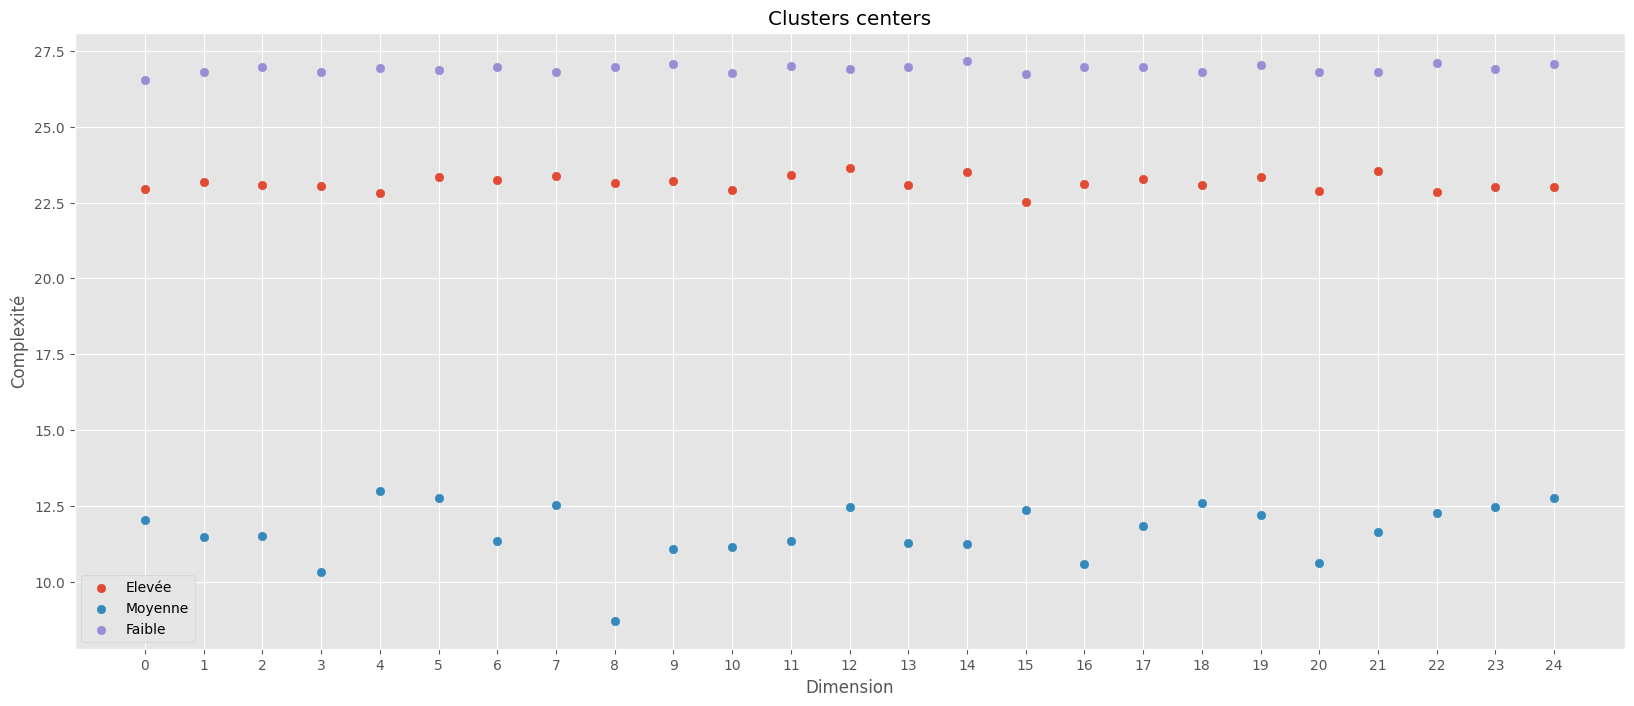

In [22]:
import random
from sklearn.cluster import KMeans

model = KMeans(n_clusters=3, random_state=42).fit(complexity24G_people)

plt.figure(figsize=(20,8))
for center in model.cluster_centers_:
    plt.scatter(x=[i for i in range(len(center))],y=center)

plt.legend(["Elevée","Moyenne","Faible"])
plt.title("Clusters centers")
plt.ylabel("Complexité")
plt.xlabel("Dimension")
# Modifier la graduation des abscisses
plt.xticks(range(len(center)))

plt.show()

# 3. Apprentissage et généralisation

### Avec les centres de KMeans

In [68]:
# Mélanger les données
data = complexity24G_people_concatenated.copy()
random.shuffle(data)

# Séparer les données pour la classification non-supervisée (k-means)
complexities_kmeans = np.array(data[:1250]).reshape(-1, 1)

# Appliquer la classification non-supervisée (k-means)
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=0).fit(complexities_kmeans)
centers = kmeans.cluster_centers_.flatten()

# Séparer les données de test pour la classification supervisée (k plus proches voisins)
complexities_knn = np.array(data[1250:]).reshape(-1, 1)

# Appliquer la classification supervisée (k plus proches voisins) en utilisant les représentants de chaque cluster
knn_with_kmeans = KNeighborsClassifier(n_neighbors=1)
knn_with_kmeans.fit(centers.reshape(-1, 1), range(3))
knn_with_kmeans_predictions = knn_with_kmeans.predict(complexities_knn)

predictions_with_kmeans = kmeans.labels_.flatten().tolist() + knn_with_kmeans_predictions.flatten().tolist()

colors = ['cluster 1','cluster 2', 'cluster 3']
cluster_colors_with_kmeans = [colors[prediction-1] for prediction in predictions_with_kmeans]
centers_colors_with_kmeans = [colors[center] for center in kmeans.predict(centers.reshape(-1, 1)).tolist()]

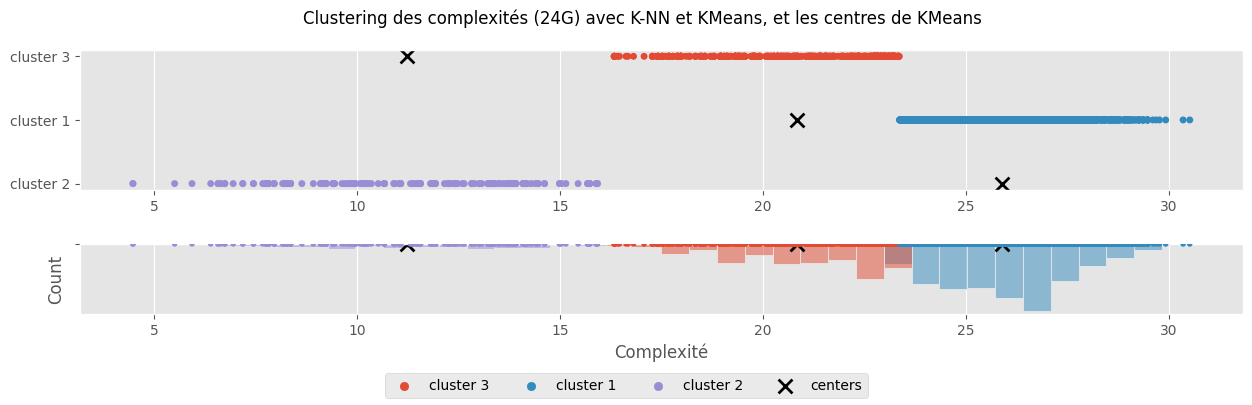

In [76]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 4))

# tracer le stripplot avec jitter=False sur le premier sous-graphique
sns.stripplot(x=data.flatten(),y=cluster_colors_with_kmeans,hue=cluster_colors_with_kmeans,jitter=False, ax=axes[0])
axes[0].scatter(centers, centroids_colors, marker='x', s=100, linewidth=2, color='k',label='centers')

# tracer le stripplot avec jitter=True sur le deuxième sous-graphique
sns.stripplot(x=data.flatten(),hue=cluster_colors_with_kmeans,jitter=False, ax=axes[1],size=4)
sns.histplot(x=data.flatten(), hue=cluster_colors_with_kmeans)
axes[1].scatter(centers, [0]*len(centers), marker='x', s=100, linewidth=2, color='k',label='centers')

# ajuster les marges et les étiquettes de la figure
plt.subplots_adjust(wspace=0.3)
title = 'Clustering des complexités ('+ str(number_gaussian) +'G) avec K-NN et KMeans, et les centres de KMeans'
plt.suptitle(title)

# créer une légende unique
axes[0].legend_.remove()
axes[1].legend_.remove()
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=len(labels))
axes[1].set_xlabel('Complexité')

# Modifier la position et la taille de la deuxième sous-figure
pos = axes[1].get_position()
axes[1].set_position([pos.x0, pos.y0*2, pos.width, pos.height/2])

# afficher la figure
plt.show()

### Comparaison avec KMeans 24G